In [3]:
from pathlib import Path
home = "dbfs:/mnt/data"

In [4]:
df = spark.read.parquet(f"{home}/data/10-processed-data.parquet")
df = df.selectExpr("features_scaled as features","Default as label")

In [5]:
#split the data into 70/30 ratio for train test purpose
train_df,test_df=df.randomSplit([0.7,0.3])

In [6]:
train_df.count()

85177

In [7]:
train_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|78308|
|  1.0| 6869|
+-----+-----+



In [8]:
test_df.count()

36679

In [9]:
test_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|33711|
|  1.0| 2968|
+-----+-----+



In [10]:
#import from spark's MLlib
from pyspark.ml.classification import LogisticRegression

In [11]:
log_reg=LogisticRegression(labelCol='label').fit(train_df)

In [12]:
#Training Results

In [13]:
lr_summary=log_reg.summary

In [14]:
lr_summary.accuracy

1.0

In [15]:
help(lr_summary)

Help on BinaryLogisticRegressionTrainingSummary in module pyspark.ml.classification object:

class BinaryLogisticRegressionTrainingSummary(BinaryLogisticRegressionSummary, LogisticRegressionTrainingSummary)
 |  .. note:: Experimental
 |  
 |  Binary Logistic regression training results for a given model.
 |  
 |  .. versionadded:: 2.0.0
 |  
 |  Method resolution order:
 |      BinaryLogisticRegressionTrainingSummary
 |      BinaryLogisticRegressionSummary
 |      LogisticRegressionTrainingSummary
 |      LogisticRegressionSummary
 |      pyspark.ml.wrapper.JavaWrapper
 |      builtins.object
 |  
 |  Data descriptors inherited from BinaryLogisticRegressionSummary:
 |  
 |  areaUnderROC
 |      Computes the area under the receiver operating characteristic
 |      (ROC) curve.
 |      
 |      .. note:: This ignores instance weights (setting all to 1.0) from
 |          `LogisticRegression.weightCol`. This will change in later Spark
 |          versions.
 |      
 |      .. versionadded

In [16]:
lr_summary.areaUnderROC

0.9999874176807151

In [17]:
print(lr_summary.precisionByLabel)

[1.0, 1.0]


In [18]:
print(lr_summary.recallByLabel)

[1.0, 1.0]


In [19]:
predictions = log_reg.transform(test_df)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,0.4209415121...|  1.0|[-22.468463147612...|[1.74610533016634...|       1.0|
|[3.01169358481887...|  0.0|[25.5857653612941...|[0.99999999999226...|       0.0|
|[3.28548391071149...|  0.0|[24.9791637713798...|[0.99999999998581...|       0.0|
|[3.55927423660412...|  0.0|[24.7164347670079...|[0.99999999998155...|       0.0|
|[4.92822586606724...|  0.0|[27.2654876449040...|[0.99999999999855...|       0.0|
|[5.74959684374512...|  0.0|[20.3307376367208...|[0.99999999851928...|       0.0|
|[5.74959684374512...|  0.0|[19.5768612630449...|[0.99999999685314...|       0.0|
|[6.57096782142299...|  0.0|[24.2154357288228...|[0.99999999996956...|       0.0|
|[7.11854847320824...|  0.0|[23.3388504226903...|[0.99999999992687...|       0.0|
|[8.487500102671

In [20]:
model_predictions = log_reg.transform(test_df)

In [21]:
model_predictions = log_reg.evaluate(test_df)

In [22]:
model_predictions.accuracy

0.9999727364431964

In [23]:
model_predictions.weightedPrecision

0.999972737251916

In [24]:
model_predictions.recallByLabel

[1.0, 0.9996630727762803]

In [25]:
print(model_predictions.precisionByLabel)

[0.9999703369719981, 1.0]


In [26]:
model_predictions.areaUnderROC

0.9996129599614801

In [27]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label")
rf_model = rf.fit(train_df)

In [28]:
model_predictions = rf_model.transform(test_df)

In [29]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

rf = RandomForestClassifier(labelCol="label")
paramGrid = (ParamGridBuilder()
#             .addGrid(rf.maxDepth, [5,10,20,25,30])
             .addGrid(rf.maxDepth, [5, 10, 20])
#             .addGrid(rf.maxBins, [20,30,40 ])
             .addGrid(rf.maxBins, [20, 30])
#             .addGrid(rf.numTrees, [5, 20,50])
             .addGrid(rf.numTrees, [5, 20])
             .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cv_model = cv.fit(train_df)

In [30]:
best_rf_model = cv_model.bestModel

In [31]:
# Generate predictions for entire dataset
model_predictions = best_rf_model.transform(test_df)

In [32]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()

In [33]:
#Recall 
float(true_pos)/(actual_pos)

0.9976415094339622

In [34]:
#Precision on test Data 
float(true_pos)/(pred_pos)

1.0

In [35]:
evaluator.evaluate(cv_model.transform(test_df))

1.0

In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [37]:
metric_names = ["areaUnderROC","areaUnderPR","recall","precision","f1", "accuracy", "weightedPrecision", \
                "weightedRecall", "weightedTruePositiveRate", "weightedFalsePositiveRate", \
                "weightedFMeasure", "truePositiveRateByLabel", "falsePositiveRateByLabel", \
                "precisionByLabel", "recallByLabel", "fMeasureByLabel", "logLoss", "hammingLoss"]

metric_names = ["f1", "accuracy", "weightedPrecision", "weightedRecall"]

dct_eval = {}
for metric_name in metric_names:
    try:
        evaluator = MulticlassClassificationEvaluator().setLabelCol("label")\
        .setPredictionCol("prediction")\
        .setMetricName(metric_name)

        print(f"{metric_name}: {evaluator.evaluate(model_predictions)}")
    except Exception as e:
        print(e)
        print("Effort for metric: ", metric_name)
    

f1: 0.9998090523491301
accuracy: 0.9998091551023747
weightedPrecision: 0.9998091947225859
weightedRecall: 0.9998091551023747


In [38]:
metric_names = ["areaUnderROC","areaUnderPR","recall","precision","f1", "accuracy", "weightedPrecision", \
                "weightedRecall", "weightedTruePositiveRate", "weightedFalsePositiveRate", \
                "weightedFMeasure", "truePositiveRateByLabel", "falsePositiveRateByLabel", \
                "precisionByLabel", "recallByLabel", "fMeasureByLabel", "logLoss", "hammingLoss"]

metric_names = ["areaUnderROC","areaUnderPR"]

dct_eval = {}
for metric_name in metric_names:
    try:
        evaluator = BinaryClassificationEvaluator().setLabelCol("label")\
        .setMetricName(metric_name)

        print(f"{metric_name}: {evaluator.evaluate(model_predictions)}")
    except Exception as e:
        print(e)
        print("Effort for metric: ", metric_name)
    

areaUnderROC: 1.0
areaUnderPR: 1.0


In [39]:
lr_result = model_predictions
sc = spark.sparkContext

In [40]:
PredAndLabels           = lr_result.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.sample(fraction=0.2).collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

In [41]:
PredAndLabels.collect()

[(0.0, 0.0),
 (0.9743129178202444, 1.0),
 (0.9743129178202444, 1.0),
 (0.9928139452152258, 1.0),
 (0.9928139452152258, 1.0),
 (0.17431291782024444, 0.0),
 (1.0, 1.0),
 (0.864447405406052, 1.0),
 (0.9743129178202444, 1.0),
 (0.9743129178202444, 1.0),
 (0.9483569502652038, 1.0),
 (1.0, 1.0),
 (0.9483569502652038, 1.0),
 (0.9928139452152258, 1.0),
 (0.9743129178202444, 1.0),
 (0.9928139452152258, 1.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.9928139452152258, 1.0),
 (0.9928139452152258, 1.0),
 (0.9032282680514067, 1.0),
 (0.9743129178202444, 1.0),
 (0.9743129178202444, 1.0),
 (0.0, 0.0),
 (0.9483569502652038, 1.0),
 (1.0, 1.0),
 (0.9483569502652038, 1.0),
 (1.0, 1.0),
 (0.9928139452152258, 1.0),
 (0.9483569502652038, 1.0),
 (0.9743129178202444, 1.0),
 (0.9928139452152258, 1.0),
 (0.9743129178202444, 1.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.9743129178202444, 1.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.9740440324449594, 1.0),
 (0.9740440324449594, 1.0),
 (0.9743129178202444, 1.0),
 (0.9743129178202444, 1.0),
 (0.

In [42]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [43]:
bcm = BinaryClassificationMetrics(PredAndLabels)

In [44]:
bcm.areaUnderROC

1.0

In [45]:
bcm.areaUnderPR

1.0

In [46]:
metrics = BinaryClassificationMetrics(PredAndLabels)

## Calculate Various Metrics

In [47]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorSlicer
import matplotlib.pyplot as plt

## ROC Curve Visualization

In [48]:
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()

y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]

In [49]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

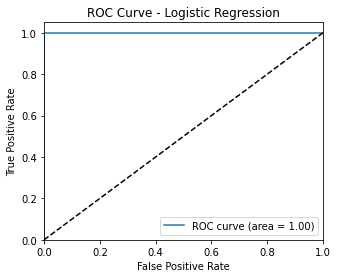

In [50]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix
- For binary and multi-class classification problems, confusion matrix is another metrics which helps in indentifying which classes are easy to predict and which are hard to predict
- It provides how many samples for each class are correctly classified and how many are confused with other classes.

In [51]:
cm_lr_result = lr_result.crosstab("prediction", "label")
cm_lr_result = cm_lr_result.toPandas()
cm_lr_result

,prediction_label,0.0,1.0
0,1.0,0,2961
1,0.0,33711,7


## Calculate Accuracy, Sensitivity, Specificity, Precision and ROC Curve

In [52]:
TP = cm_lr_result["1.0"][0]
FP = cm_lr_result["0.0"][0]
TN = cm_lr_result["0.0"][1]
FN = cm_lr_result["1.0"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

In [53]:
print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 1.00
Sensitivity = 1.00
Specificity = 1.00
Precision = 1.00


In [54]:
lr_result.select('label', 'prediction', 'probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  1.0|       1.0|           [0.0,1.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|[0.97431291782024...|
|  0.0|       0.0|[0.97431291782024...|
|  0.0|       0.0|[0.97431291782024...|
+-----+----------+--------------------+
only showing top 5 rows



In [55]:
pred_pd = lr_result.select(['label', 'prediction', 'probability']).toPandas()

In [56]:
pred_pd.head()

,label,prediction,probability
0,1.0,1.0,"[0.0, 1.0]"
1,0.0,0.0,"[1.0, 0.0]"
2,0.0,0.0,"[0.9743129178202444, 0.025687082179755554]"
3,0.0,0.0,"[0.9743129178202444, 0.025687082179755554]"
4,0.0,0.0,"[0.9743129178202444, 0.025687082179755554]"


- We need to convert the column prediction into a list, because now it is of type VectorDense. We will create a new column encoded_label that we will use to plot the roc curve.

In [57]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_label'] = pred_pd['label'].map(lambda x: np.eye(2)[int(x)])

In [58]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_label'].tolist())

In [59]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt 

fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

print('AUC: {:.3f}'.format(auc))

AUC: 1.000


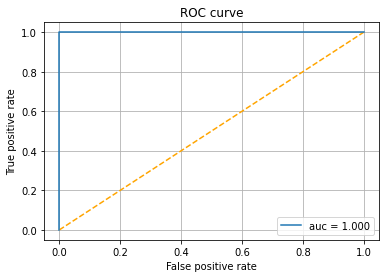

In [60]:
import matplotlib.pyplot as plt 

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Import SKLearn for various matrics
- We can use SKLearn for various useful matrics

In [87]:
import sklearn
from sklearn import metrics, datasets, neighbors

import sys
import warnings
import itertools

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc,average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import fbeta_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

In [89]:
lr_result

DataFrame[features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

In [64]:
Y_test = lr_result.select("label").toPandas()['label']

In [65]:
Y_preds = lr_result.select("Prediction").toPandas()['Prediction']

In [90]:
conf_mat = confusion_matrix(Y_test, Y_preds)
print(conf_mat)

[[33711     0]
 [    7  2961]]


## Visualize Confusion Matrix

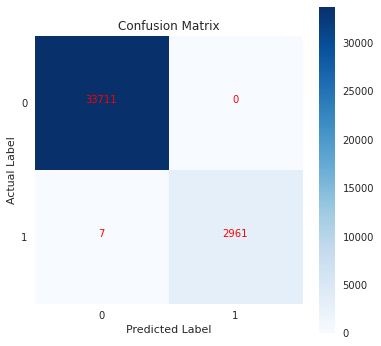

In [67]:
with plt.style.context(('ggplot', 'seaborn')):
    fig = plt.figure(figsize=(6,6), num=1)
    plt.imshow(conf_mat, interpolation='nearest',cmap= plt.cm.Blues )
    plt.xticks([0,1],[0,1])
    plt.yticks([0,1],[0,1])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
                plt.text(j, i,conf_mat[i, j], horizontalalignment="center",color="red")
    plt.grid(None)
    plt.title('Confusion Matrix')
    plt.colorbar();

## Use SKLearn library to calculate various matrics

In [92]:
print('Test MAE  : %.3f'%mean_absolute_error(Y_test, Y_preds))

Test MAE  : 0.000


In [93]:
print('Test MSE  : %.3f'%mean_squared_error(Y_test, Y_preds))

Test MSE  : 0.000


In [94]:
print(mean_squared_log_error(Y_test, Y_preds))

9.169200625500722e-05


In [95]:
print('Maximum Residual Error : ', max_error(Y_test, Y_preds))

Maximum Residual Error :  1.0


In [96]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

print('Precision                                   : %.3f'%precision_score(Y_test, Y_preds))
print('Recall                                      : %.3f'%recall_score(Y_test, Y_preds))
print('F1-Score                                    : %.3f'%f1_score(Y_test, Y_preds))
print('\nPrecision Recall F1-Score Support Per Class : \n',precision_recall_fscore_support(Y_test, Y_preds))
print('\nClassification Report                       : ')
print(classification_report(Y_test, Y_preds))

Precision                                   : 1.000
Recall                                      : 0.998
F1-Score                                    : 0.999

Precision Recall F1-Score Support Per Class : 
 (array([0.9997924, 1.       ]), array([1.        , 0.99764151]), array([0.99989619, 0.99881936]), array([33711,  2968]))

Classification Report                       : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33711
         1.0       1.00      1.00      1.00      2968

    accuracy                           1.00     36679
   macro avg       1.00      1.00      1.00     36679
weighted avg       1.00      1.00      1.00     36679



In [97]:
accuracy = metrics.accuracy_score(Y_test, Y_preds)
accuracy 

0.9998091551023747

In [98]:
precision_positive = metrics.precision_score(Y_test, Y_preds, pos_label=1)
precision_negative = metrics.precision_score(Y_test, Y_preds, pos_label=0)
precision_positive, precision_negative 

(1.0, 0.9997923957530103)

In [99]:
recall_sensitivity = metrics.recall_score(Y_test, Y_preds, pos_label=1)
recall_specificity = metrics.recall_score(Y_test, Y_preds, pos_label=0)
recall_sensitivity, recall_specificity 

(0.9976415094339622, 1.0)

In [100]:
f1_positive = metrics.f1_score(Y_test, Y_preds, pos_label=1)
f1_negative = metrics.f1_score(Y_test, Y_preds, pos_label=0)
f1_positive, f1_negative 

(0.998819362455726, 0.9998961871005058)

In [101]:
print(metrics.classification_report(Y_test, Y_preds))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     33711
         1.0       1.00      1.00      1.00      2968

    accuracy                           1.00     36679
   macro avg       1.00      1.00      1.00     36679
weighted avg       1.00      1.00      1.00     36679



### Hamming Loss
Hamming loss is the fraction of targets that are misclassified. The best value of the hamming loss is 0 and the worst value is 1. It can be calculated as 

In [108]:
metrics.hamming_loss(Y_test, Y_preds)

0.0001908448976253442

### Cross-entropy loss
Cross-entropy loss, also known as log loss

In [111]:
metrics.log_loss(Y_test, Y_preds)

0.006591549245192382

## Visualize Precision & Recall vs Threshold

In [104]:
prob_tests = lr_result.select("probability").toPandas()['probability']

In [105]:
prob_test = [my_prob_test[0] for my_prob_test in prob_tests]

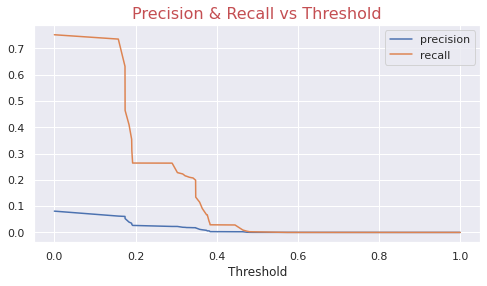

In [106]:
pre, rec, thr = metrics.precision_recall_curve(Y_test, prob_test)
plt.figure(figsize=(8,4))
plt.plot(thr, pre[:-1], label='precision')
plt.plot(thr, rec[1:], label='recall')
plt.xlabel('Threshold')
plt.title('Precision & Recall vs Threshold', c='r', size=16)
plt.legend()
plt.show()

In [ ]:
spark.stop()